In [1]:
import os
import torch
import transformers
import datasets
import huggingface_hub

import matplotlib.pyplot as plt
from tqdm import tqdm

### Initialization

In [2]:
datasets.disable_caching()

In [3]:
project_dir = '/Users/christopher/Documents/unireps'
# project_dir = '/net/scratch2/chriswolfram/unireps'
cache_dir = os.path.join(project_dir, 'hf_cache')
output_dir = os.path.join(project_dir, 'outputs')

In [158]:
def output_name(model_name, dataset_name):
    return '{}---{}'.format(model_name.replace('/', '__'), dataset_name)

def model_dataset_output(model_name, dataset_name):
    return datasets.load_from_disk(os.path.join(output_dir, output_name(model_name, dataset_name)))

def output_embeddings(ds, layer=-1, type='last', normalize=True):
    assert type == 'last' or type == 'mean'
    if type == 'last':
        key = 'layer_last_embeddings'
    elif type == 'mean':
        key = 'layer_mean_embeddings'

    if layer is None:
        embs = torch.stack([e[key] for e in ds]).permute(1,0,2)
    else:
        embs = torch.stack([e[key][layer] for e in ds])

    if normalize:
        embs = torch.nn.functional.normalize(embs, dim=-1)

    return embs

### Similarity measures

In [125]:
# Uses dot product to get the distance. Currently does not even normalize.
def embs_knn(emb_mat, k):
    gram = emb_mat @ emb_mat.T
    gram.fill_diagonal_(-torch.inf)

    return gram.topk(k, sorted=False).indices

def mutual_knn(knn_mat_1, knn_mat_2):

    assert knn_mat_1.shape == knn_mat_2.shape
    n = knn_mat_1.shape[0]
    k = knn_mat_1.shape[1]

    total = 0
    for i in range(n):
        total += torch.isin(knn_mat_1[i], knn_mat_2[i], assume_unique=True).sum()
    
    return (total / (k * n)).item()

### Scatter plots

In [71]:
embs_1 = output_embeddings(model_dataset_output('google/gemma-2-2b', 'imdb').take(1024), -3, 'last', normalize=True)
embs_2 = output_embeddings(model_dataset_output('google/gemma-2-9b', 'imdb').take(1024), -3, 'last', normalize=True)

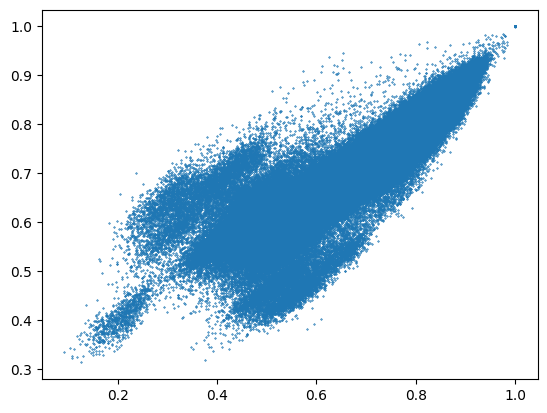

In [72]:
plt.scatter((embs_1 @ embs_1.T).flatten(), (embs_2 @ embs_2.T).flatten(), s=0.1)
plt.show()

### Identical embeddings

In [99]:
ds = model_dataset_output('google/gemma-2-2b', 'imdb').take(1024)
embs = output_embeddings(ds, -3, 'last', normalize=True)

In [100]:
(embs @ embs.T).fill_diagonal_(-torch.inf).flatten().topk(10).values

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9989, 0.9989, 0.9845,
        0.9845])

In [116]:
flat_indices = torch.tensor([(a,b) for a in range(len(ds)) for b in range(len(ds))]).flatten(end_dim=-2)
top_indices = (embs @ embs.T).fill_diagonal_(-torch.inf).flatten().topk(10).indices
flat_indices[top_indices]

tensor([[167, 168],
        [168, 167],
        [663, 664],
        [664, 663],
        [701, 699],
        [699, 701],
        [195, 194],
        [194, 195],
        [836,  66],
        [ 66, 836]])

In [120]:
print(ds[167]['text'])
print(ds[168]['text'])

I am not so much like Love Sick as I image. Finally the film express sexual relationship of Alex, kik, Sandu their triangle love were full of intenseness, frustration and jealous, at last, Alex waked up and realized that they would not have result and future.Ending up was sad.<br /><br />The director Tudor Giurgiu was in AMC theatre on Sunday 12:00PM on 08/10/06, with us watched the movie together. After the movie he told the audiences that the purposed to create this film which was to express the sexual relationships of Romanian were kind of complicate.<br /><br />On my point of view sexual life is always complicated in everywhere, I don't feel any particular impression and effect from the movie. The love proceeding of Alex and Kiki, and Kiki and her brother Sandu were kind of next door neighborhood story.<br /><br />The two main reasons I don't like this movie are, firstly, the film didn't told us how they started to fall in love? Sounds like after Alex moved into the building which 

In [121]:
print(ds[66]['text'])
print(ds[836]['text'])

There's not a drop of sunshine in "The Sunshine Boys", which makes the title of this alleged comedy Neil Simon's sole ironic moment. Simon, who adapted the script from his play (which goes uncredited), equates old age with irrational behavior--and, worse, clumsy, galumphing, mean-spirited irrational behavior. Walter Matthau is merciless on us playing an aged vaudeville performer talked into reuniting with former comedy partner George Burns for a television special (it's said they were a team for 43 years, which begs the question "how long did vaudeville last, anyway?"). Burns, who won a Supporting Oscar, has the misfortune of coming to the film some thirty minutes in, after which time Matthau has already blasted the material to hell and back. The noisier the movie gets, the less tolerable and watchable it is. Director Herbert Ross only did solid work when he wasn't coupled with one of Neil Simon's screenplays; here, Ross sets up gags like a thudding amateur, hammering away at belligere

### Layer pair matrices

In [159]:
embs_1 = output_embeddings(model_dataset_output('google/gemma-2-2b', 'imdb').take(1024), None, 'last', normalize=True)
embs_2 = output_embeddings(model_dataset_output('google/gemma-2-9b', 'imdb').take(1024), None, 'last', normalize=True)

In [191]:
def layer_similarities(embs_1, embs_2, k):
    knn_1 = torch.stack([embs_knn(e, k) for e in embs_1])
    knn_2 = torch.stack([embs_knn(e, k) for e in embs_2])

    out = torch.zeros(len(knn_1), len(knn_2))
    for i in tqdm(range(len(knn_1))):
        for j in range(len(knn_2)):
            out[i,j] = mutual_knn(knn_1[i], knn_2[j])

    return out

100%|██████████| 27/27 [00:05<00:00,  4.62it/s]


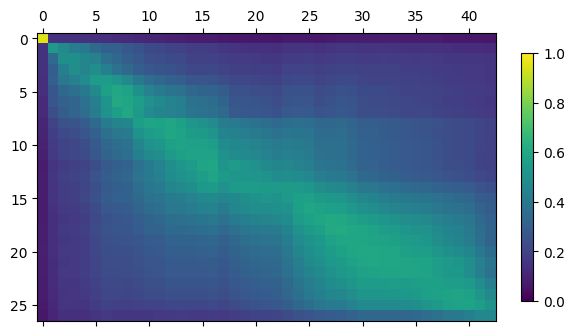

In [192]:
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(layer_similarities(embs_1, embs_2, 10), vmin=0, vmax=1)
fig.colorbar(cax, fraction=0.025)
plt.show()

100%|██████████| 27/27 [00:03<00:00,  7.27it/s]


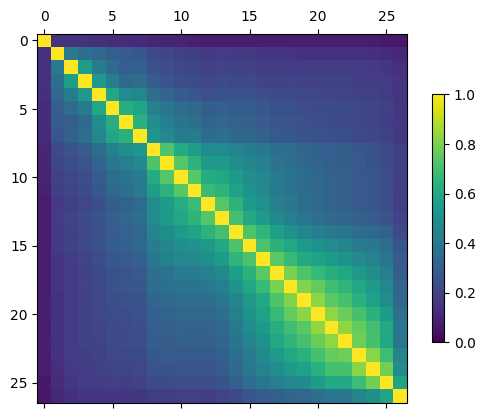

In [193]:
fig = plt.figure()
ax = fig.add_subplot()
cax = ax.matshow(layer_similarities(embs_1, embs_1, 10), vmin=0, vmax=1)
fig.colorbar(cax, fraction=0.025)
plt.show()

### Experiments

In [140]:
embs_1 = output_embeddings(model_dataset_output('google/gemma-2-2b', 'imdb').take(1024), -3, 'last', normalize=True)
embs_2 = output_embeddings(model_dataset_output('google/gemma-2-9b', 'imdb').take(1024), -3, 'last', normalize=True)

In [151]:
knn_1 = embs_knn(embs_1, 10)
knn_2 = embs_knn(embs_2, 10)
mutual_knn(knn_1, knn_2)

0.5711914300918579

In [150]:
knn_1_permuted = embs_knn(embs_1[torch.randperm(len(embs_1))], 10)
knn_2 = embs_knn(embs_2, 10)
mutual_knn(knn_1_permuted, knn_2)

0.010937499813735485